# *BEATS CT reconstruction pipeline - Paganin phase retrieval*
Minimal [TomoPy](https://tomopy.readthedocs.io/en/latest/) reconstruction pipeline for **phase contrast** data collected at the [BEATS beamline](https://beats-sesame.eu/) of [SESAME](https://www.sesame.org.jo/).

Created on:  23.05.2021 <br />
Last update: 31.07.2023 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2023
- Code license: MIT
- Narrative license: CC-BY-NC-SA

Type `Ctrl` + `Enter` on a single cell to run it.

## Load experiment data
Enter the **sample_name** and the correct **output_dir** 

In [1]:
sample_name = "fiber_test_fast-20230731T185659"
work_dir = "/PETRA/SED/BEATS/IH/"+sample_name
h5file = work_dir+"/"+sample_name+".h5"

output_dir = "/home/beatsbs/Data/AlHandawi/"
recon_dir = output_dir+sample_name+"/recon/"
cor_dir = output_dir+sample_name+"/cor/"

### Load the complete dataset (or)

In [ ]:
# projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0)

### Read a portion of the dataset
- `sino` controls the vertical detector lines to read - `sino=(10, 2161, 1)`
- `proj` defines the range of projections - `proj=(1, 401, 1)`

In [2]:
projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0, sino=(700, 800, 1), proj=(1, 401, 1))
# projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0, sino=(700, 800, 1))

print("Dataset size: ", projs[:, :, :].shape[:], " - dtype: ", projs.dtype)
print("Flat fields size: ", flats[:, :, :].shape[:])
print("Dark fields size: ", darks[:, :, :].shape[:])
print("Theta array size: ", theta.shape[:])

INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/fiber_test_fast-20230731T185659/fiber_test_fast-20230731T185659.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/fiber_test_fast-20230731T185659/fiber_test_fast-20230731T185659.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/fiber_test_fast-20230731T185659/fiber_test_fast-20230731T185659.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/fiber_test_fast-20230731T185659/fiber_test_fast-20230731T185659.h5


Dataset size:  (400, 100, 1216)  - dtype:  uint16
Flat fields size:  (41, 100, 1216)
Dark fields size:  (41, 100, 1216)
Theta array size:  (1201,)


At any time you can take a look at your 3D data with `ru.plotmidplanes(data)`

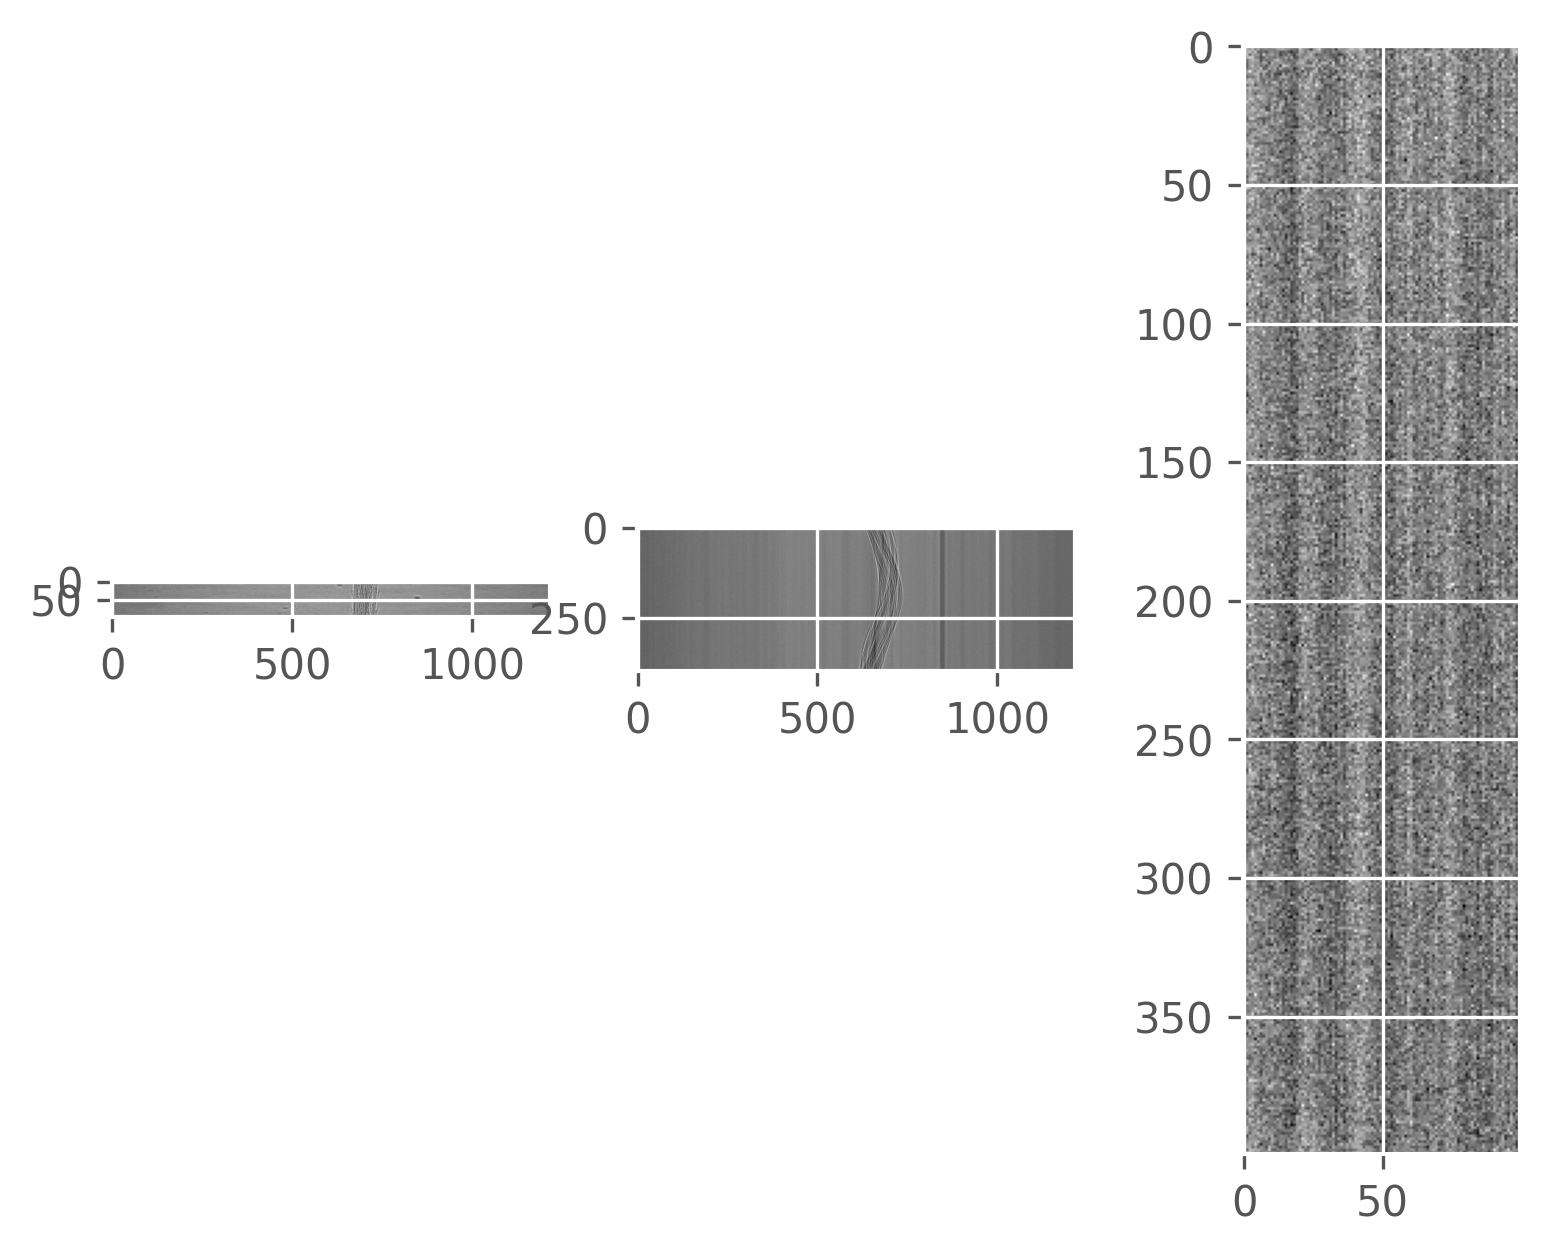

In [4]:
ru.plot_midplanes(projs)

## Flat field correction
Normalize the image background.

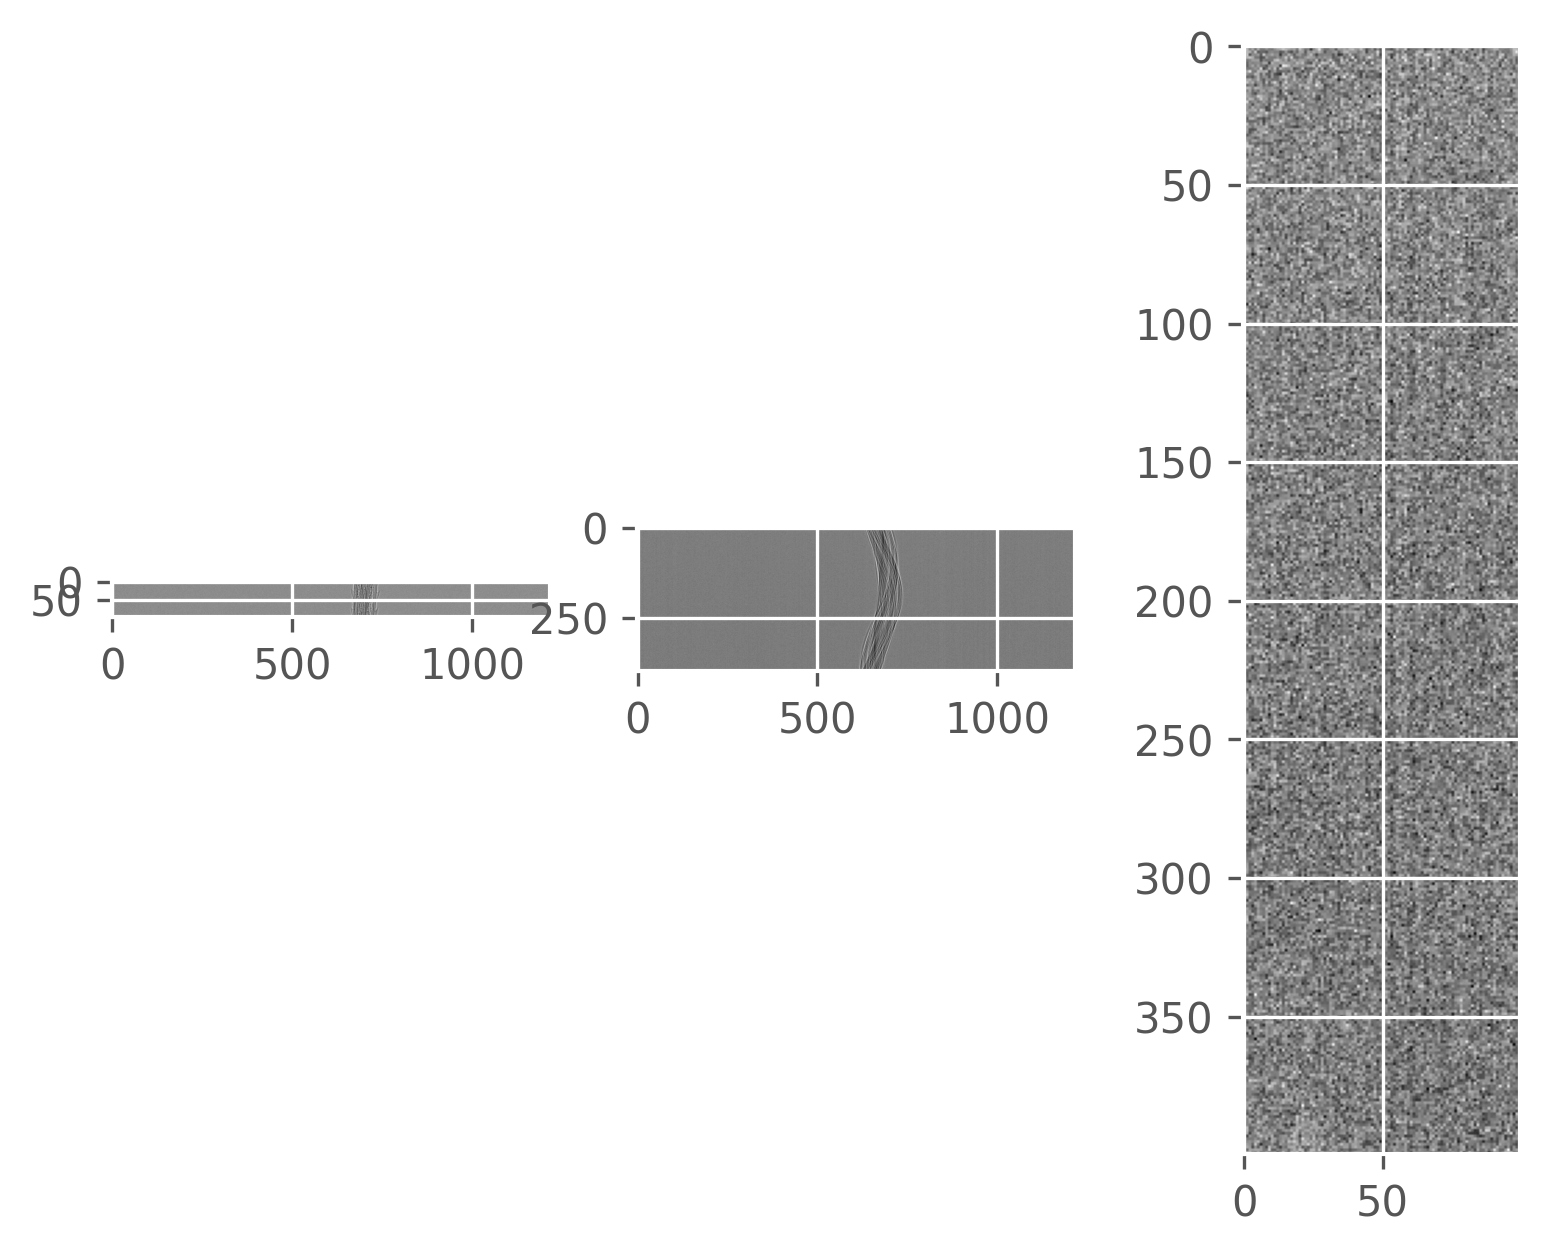

In [3]:
projs = tomopy.normalize(projs, flats, darks, ncore=ncore, averaging='median')
ru.plot_midplanes(projs)

## Phase retrieval

In [4]:
delta_beta = 125 # 250 # ratio between real and imaginary part of the refractive index
alpha=1./(4*3.141592**2 * delta_beta)
print("alpha: ", alpha)

alpha:  0.0002026424516017967


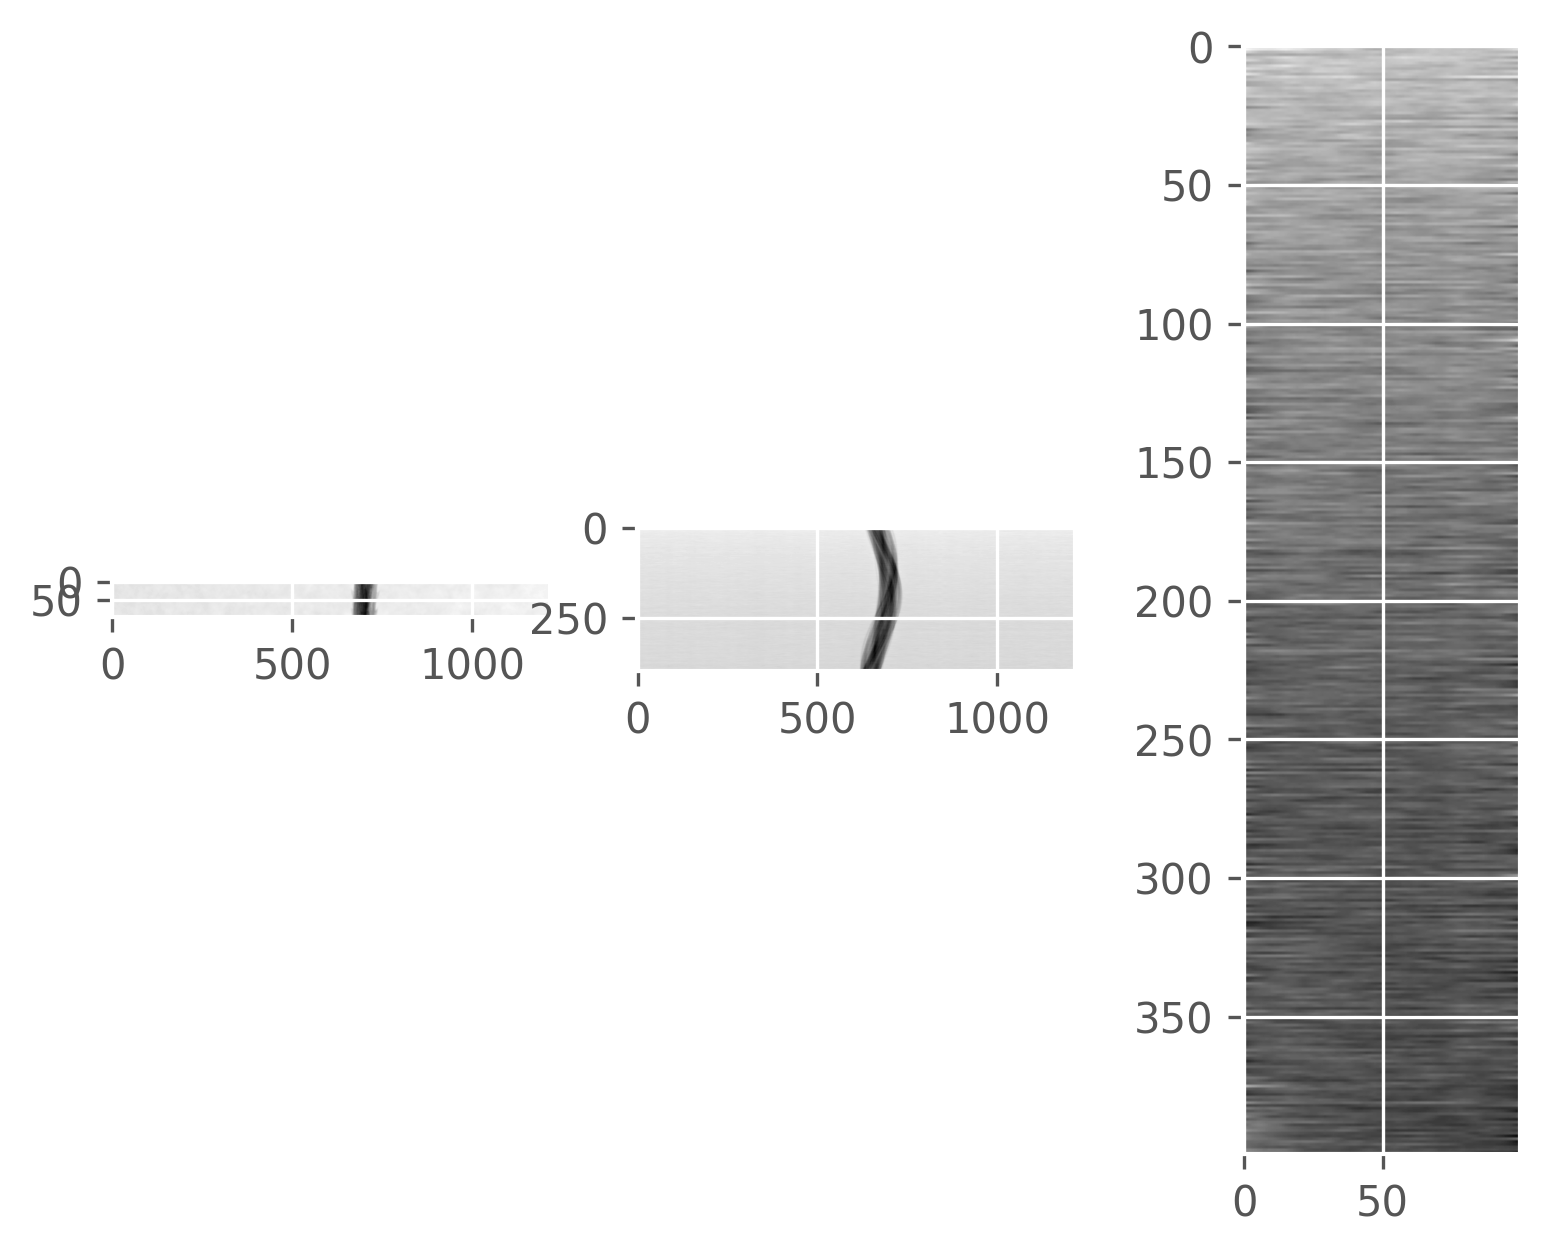

In [5]:
projs_phase = tomopy.retrieve_phase(projs[:, :, :],
                                    pixel_size=1e-4*0.65,
                                    dist=2,
                                    energy=10,
                                    alpha=alpha,
                                    ncore=ncore,
                                    pad=True)
# nchunk=None,

ru.plot_midplanes(projs_phase)

In [7]:
projs_phase.dtype

dtype('float32')

## Log transform
Calculate $ -log(projs) $ to linearize transmission tomography data.

In [8]:
projs_phase = tomopy.minus_log(projs_phase, ncore=ncore)

## Center Of Rotation (COR)
### Save images reconstructed with COR range

In [23]:
cor_range = [1260, 1300, 1]

In [ ]:
tomopy.write_center(projs, theta, cor_dir, cor_range)

View them in Fiji

In [5]:
# os.system(Fiji_exe_stack + cor_dir+'{:04.2f}'.format(COR[0])+'.tiff &')

Manually insert the best `COR`

In [8]:
COR = 671

### Automatic detect COR

In [ ]:
# COR = tomopy.find_center(projs, theta, init=projs.shape[2]/2, tol=0.5) # ind=200, 
# print("Automatic detected COR: ", COR, " - tomopy.find_center")

COR = tomopy.find_center_vo(projs, ncore=ncore)
print("Automatic detected COR: ", COR, " - tomopy.find_center_vo")

## Reconstruction
### GPU reconstruction with the ASTRA toolbox
|  |  |
| :--- | :--- |
| **Algorithm**      | `fbp CUDA ASTRA` |

In [ ]:
options = {'proj_type': 'cuda', 'method': 'FBP_CUDA'}

recon = tomopy.recon(projs_phase,
                     theta[1:401],
                     center=COR,
                     algorithm=tomopy.astra,
                     options=options,
                     ncore=1)

INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


## Write reconstructed dataset
Write output tiff stack as `float32`

In [29]:
fileout = recon_dir+'slice.tiff'
dxchange.writer.write_tiff_stack(recon, fname=fileout, axis=0, digit=4, start=0, overwrite=True)

Open virtual stack in ImageJ

In [ ]:
# os.system(Fiji_exe_stack + fileout + ' &')